# 1. Quickstart: Create MAPP problems and solve them using default roadmap construction methods

Welcome to JAXMAPP! In this tutorial, we introduce how to create problem instances for multi-agent path planning (MAPP) and solve them using default roadmap construction methods.

## Create a problem instance

2022-12-12 21:38:42.960976: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-12 21:38:43.549360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-12 21:38:43.549500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-12 21:38:43.549507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


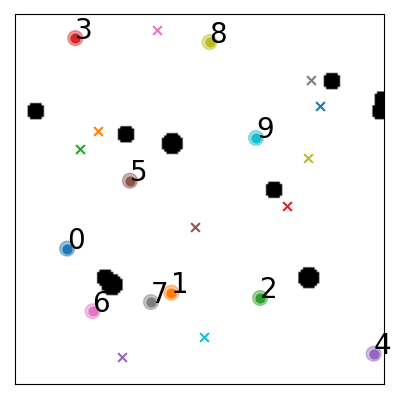

In [1]:
import jax 
from jaxmapp.env import InstanceGeneratorCircleObs
from jaxmapp.utils import viz

key = jax.random.PRNGKey(46)
generator = InstanceGeneratorCircleObs(num_agents_min=10, num_agents_max=10, 
                                        max_speeds_cands=[0.04], rads_cands=[0.02],
                                        map_size=160, num_obs=10)
ins = generator.generate(key)

viz.simple_plot_2d(ins)

By setting `num_agents_min` and `num_agents_max` differently you can sample problem instances with variable numbers of agents.

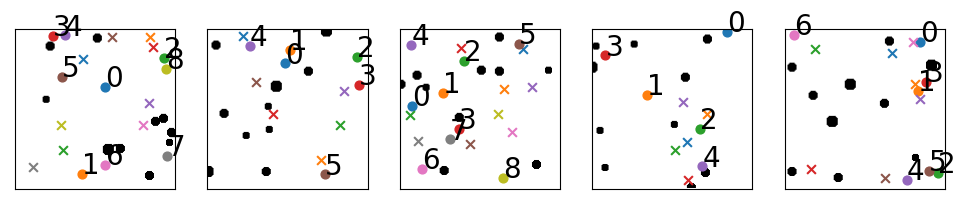

In [2]:
import matplotlib.pyplot as plt

generator = InstanceGeneratorCircleObs(num_agents_min=1, num_agents_max=10, 
                                        max_speeds_cands=[0.04], rads_cands=[0.02],
                                        map_size=160, num_obs=10)

fig, axes = plt.subplots(1, 5, figsize=[12, 3])
for i in range(5):
    ins = generator.generate(jax.random.PRNGKey(i))
    viz.simple_plot_2d(ins, ax=axes[i])

You can also load binary images to define occupancy maps.

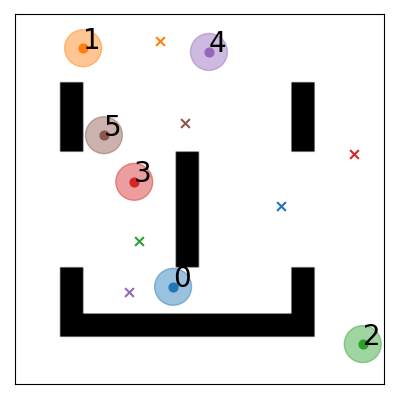

In [3]:
import numpy as np
from jaxmapp.env import InstanceGeneratorImageInput

# image input
image = np.zeros((160, 160))
image[20:30, 30:60] = 1
image[20:30, 110:140] = 1
image[120:130, 30:60] = 1
image[70:80, 60:110] = 1
image[120:130, 110:140] = 1
image[20:130, 130:140] = 1

generator = InstanceGeneratorImageInput(num_agents_min=6, num_agents_max=6, 
                                                max_speeds_cands=[0.25], rads_cands=[0.05],
                                                image=image)
ins = generator.generate(key)
viz.simple_plot_2d(ins)

Or from image collection stored in a local directory.

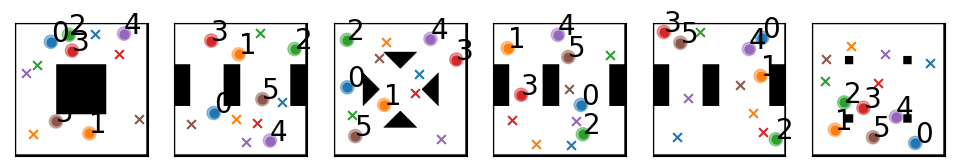

In [4]:
from jaxmapp.env import InstanceGeneratorImageCollectionInput

generator = InstanceGeneratorImageCollectionInput(num_agents_min=6, num_agents_max=6, 
                                                max_speeds_cands=[0.25], rads_cands=[0.05],
                                                imagedir="../data_example/map_data")

fig, axes = plt.subplots(1, 6, figsize=[12, 3])
for i in range(6):
    ins = generator.generate(jax.random.PRNGKey(i))
    viz.simple_plot_2d(ins, ax=axes[i])

The function `generater.generate` generates an instance of `Instance`. This instance has some attributes and functions to describe the obstacle information by using [pymap2d](https://github.com/danieldugas/pymap2d). Specifically, `ins.obs.occupancy` and `ins.obs.sdf` repsectively describe the occupancy map and its signed distance function. Additionally, `ins.calc_cost_to_go_maps` computes the distance from each pixel to agent goals using the dijkstra algorithm.

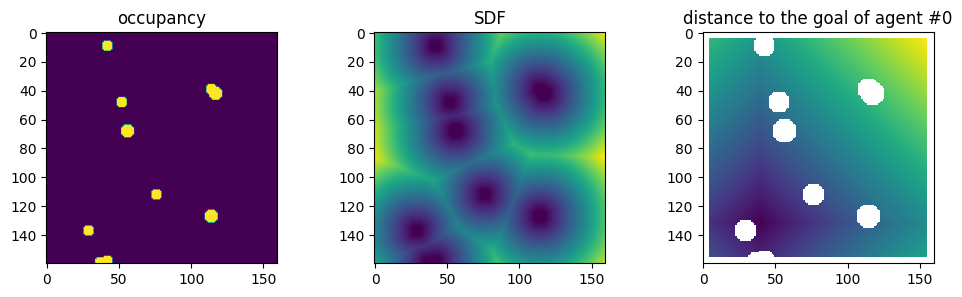

In [5]:
generator = InstanceGeneratorCircleObs(num_agents_min=10, num_agents_max=10, 
                                        max_speeds_cands=[0.04], rads_cands=[0.02],
                                        map_size=160, num_obs=10)
ins = generator.generate(key)

fig, axes= plt.subplots(1, 3, figsize=[12, 3])
axes[0].imshow(ins.obs.occupancy)
axes[0].set_title("occupancy");
axes[1].imshow(ins.obs.sdf)
axes[1].set_title("SDF");
cost_maps = ins.calc_cost_to_go_maps()
axes[2].imshow(cost_maps[0])
axes[2].set_title("distance to the goal of agent #0");

## Construct roadmaps

By default, JAXMAPP implements three sampling techniques for constructing roadmaps (`TimedRoadmap`; often abbreviated by `trms` in our code): grid sampling (`GridSampler`), random sampling (`RandomSampler`) and coopertative timed roadmaps (`CTRMSampler`) that we proposed in our work. As will be introduced in the next tutorial, all of these samplers are a subclass of `DefaultSampler` and you can develop and evaluate your own sampler in the same fashion.

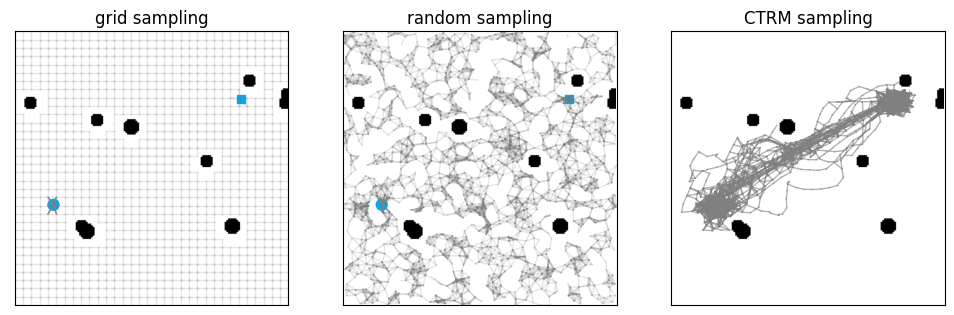

In [6]:
from jaxmapp.roadmap import GridSampler, RandomSampler, load_learned_sampler
import matplotlib.pyplot as plt

# instance generation
generator = InstanceGeneratorCircleObs(num_agents_min=10, num_agents_max=10, 
                                        max_speeds_cands=[0.04], rads_cands=[0.02],
                                        map_size=160, num_obs=10)
ins = generator.generate(key)

# Grid sampling
grid_sampler = GridSampler(share_roadmap=True, num_samples=1200, max_T=64)
trms_grid = grid_sampler.construct_trms(key, ins)

# Random sampling
random_sampler = RandomSampler(share_roadmap=True, num_samples=1600, max_T=64)
trms_random = random_sampler.construct_trms(key, ins)

# CTRM; it requires to load pretrained model weights as well as hydra config files
ctrm_sampler = load_learned_sampler(model_yaml="../scripts/config/model/ctrm.yaml",
                                           model_dir="../model/training_hetero_k05",
                                           sampler_yaml="../scripts/config/sampler/ctrm.yaml", 
                                           sampler_args={"num_samples":25, "rw_type": "uniform"})
trms_ctrm = ctrm_sampler.construct_trms(key, ins)

# visualization
fig, axes = plt.subplots(1, 3, figsize=[12, 4])
viz.plot_trms(ins, trms_grid, ax=axes[0])
axes[0].set_title("grid sampling");
viz.plot_trms(ins, trms_random, ax=axes[1])
axes[1].set_title("random sampling");
viz.plot_trms(ins, trms_ctrm, is_timed=True, ax=axes[2])
axes[2].set_title("CTRM sampling");

## Find a solution with prioritized planning

Roadmaps once constructed can be used to find a solution for MAPP using prioritized planning.

res_grid=Status: solved, makespan: 35.00, sum-of-costs: 262.00, sum-of-costs (normed): 26.20
res_random=Status: solved, makespan: 37.00, sum-of-costs: 244.00, sum-of-costs (normed): 24.40
res_ctrm=Status: solved, makespan: 31.00, sum-of-costs: 219.00, sum-of-costs (normed): 21.90


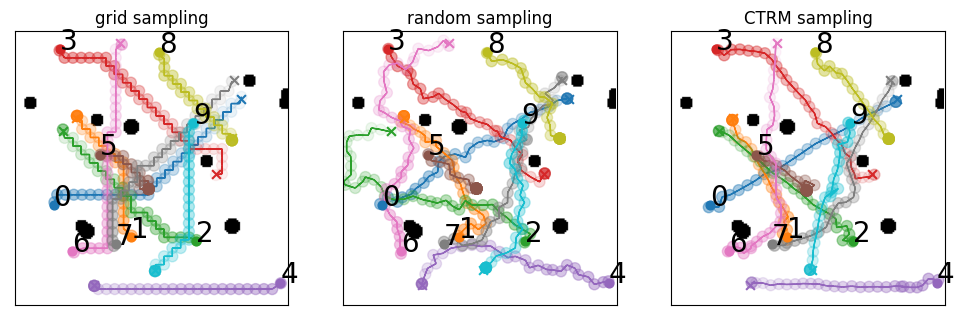

In [7]:
from jaxmapp.planner import PrioritizedPlanning

planner = PrioritizedPlanning(verbose=0)
res_grid = planner.solve(ins.to_numpy(), trms_grid)
res_random = planner.solve(ins.to_numpy(), trms_random)
res_ctrm = planner.solve(ins.to_numpy(), trms_ctrm)
print(f"{res_grid=}")
print(f"{res_random=}")
print(f"{res_ctrm=}")


fig, axes = plt.subplots(1, 3, figsize=[12, 4])
viz.simple_plot_2d(ins, res_grid, ax=axes[0])
axes[0].set_title("grid sampling");
viz.simple_plot_2d(ins, res_random, ax=axes[1])
axes[1].set_title("random sampling");
viz.simple_plot_2d(ins, res_ctrm, ax=axes[2])
axes[2].set_title("CTRM sampling");
